In [2]:
# Import necessary libraries
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
from dash import Dash, html, dcc
import dash_mantine_components as dmc
from dash.dependencies import Input, Output
from flask import Flask
import datetime as dt
from shapely.geometry import MultiPoint, mapping


In [3]:
fn = r'C:\Users\markd\projects\Hamilton County Homes\kx-ohio-school-districts-SHP'
os.chdir(fn)
# open it...
geodf = gpd.read_file(list(Path.cwd().glob("ohio*.shp"))[0])


In [4]:
fn = r'C:\Users\markd\projects\Hamilton County Homes'
os.chdir(fn)
# open it...
homes = gpd.read_file(list(Path.cwd().glob("finalsold2009_2023.csv"))[0])


In [5]:
# Convert market land value from string to float, cleaning up currency formatting
homes['market_land_value_num'] = homes['market_land_value'].replace('[\$,]', '', regex=True).astype(float)

# Group the data by 'latitude' and calculate the average market land value for each latitude
average_land_value_by_latitude = homes.groupby('latitude')['market_land_value_num'].mean().reset_index()

# Find the latitudes with the highestdata average market land value
highest_land_values = average_land_value_by_latitude.sort_values(by='market_land_value_num', ascending=False).head()

highest_land_values

,latitude,market_land_value_num
89,39.1465623,242610.0
27,39.1436349,239560.0
185,39.186685,221980.0
652,39.2495471,214620.0
91,39.1466163,209820.0


In [6]:
homes = homes.drop(columns=['foreclosure','cauv_value','tif_value','exempt_value','new_address','missing_house_number','num_amount'])

In [77]:
homes['month_yr']= homes['transfer_date'].dt.strftime('%m/%Y')

In [7]:
geodf = geodf.rename(columns={'ID':'district_id'})

In [8]:
geodf['created_da'] = pd.to_datetime(geodf['created_da'])
geodf['last_edi_1'] = pd.to_datetime(geodf['last_edi_1'])

In [9]:
geodf = geodf.drop(columns=['created_da','last_edi_1'])

In [12]:
# Define constants for the script
FN = r'C:\Users\markd\projects\Hamilton County Homes\kx-ohio-school-districts-SHP'
DISTRICT_NAMES = ['SYCAMORE', 'WYOMING', 'MADEIRA','MARIEMONT','LOVELAND']
ODE_IRN_LIST = ['044867','045146','044289','044313','044271']
MAP_CENTER = dict(lat=39.2127649, lon=-84.3831728)
COLORSCALE = {
     '044867':'rgba(0, 38, 66,.1)',    
     '045146':'rgba(132, 0, 50,.1)',
     '044289':'rgba(0, 187, 249,.1)',
     '044313':'rgba(0, 245, 212,.1)',
    '044271':'rgba(175, 43, 191,.1)',
}

district_color_map = {
    'SYCAMORE CSD': ' rgba(132, 0, 50,1)',
    'WYOMING CSD': 'rgba(0, 38, 66,1)',
    'MADEIRA CSD': 'rgba(0, 187, 249,1)',
    'MARIEMONT CSD': 'rgba(0, 245, 212,1)',
    'LOVELAND CSD':'rgba(175, 43, 191,1)'
    # Add more districts and colors as needed
}



def read_shapefile(directory, pattern):
    """Read the shapefile and return a GeoDataFrame."""
    os.chdir(directory)
    shapefile_path = list(Path.cwd().glob(pattern))[0]
    return gpd.read_file(shapefile_path)

def filter_districts(geodf, district_names):
    """Filter GeoDataFrame for specified districts and assign unique IDs."""
    filtered = geodf[geodf.NAME.str.contains('|'.join(district_names))].copy()
    unique_districts = filtered['NAME'].unique()
    district_mapping = {name: i for i, name in enumerate(unique_districts, start=1)}
    filtered['district_id'] = filtered['NAME'].map(district_mapping)
    return filtered

def create_choroplethmapbox(geodf, colorscale):
    """Create a Choroplethmapbox trace from a GeoDataFrame."""
    return go.Choroplethmapbox(
        geojson=json.loads(geodf.to_json()),
        locations=geodf.index,
        z=geodf['district_id'],
        text=geodf.NAME.str.title(),
        colorscale=geodf['ODE_IRN'].map(COLORSCALE ).fillna('rgba(126, 232, 250, 0.25)'),
        marker_line_width=3,
        marker_opacity=0.7
    )

def create_bounding_box(homes, district_color_map):
    traces = []  # List to hold all plot traces
    
    for year in homes['year'].unique():
        filtered_homes = homes[homes['year'] == year]
        
        for district in filtered_homes['school_district'].unique():
            filtered_districts = filtered_homes[filtered_homes.school_district == district]
            lat_list = filtered_districts.latitude.astype('float').tolist()
            lng_list = filtered_districts.longitude.astype('float').tolist()
            
            # Create a MultiPoint object from the points
            points = list(zip(lng_list, lat_list))
            if len(points) > 1:
                multi_point = MultiPoint(points)
                
                # Compute the convex hull
                convex_hull = multi_point.convex_hull
                
                # Check the type of convex hull
                if isinstance(convex_hull, Polygon):
                    hull_x, hull_y = convex_hull.exterior.xy
                    mode = 'lines'
                    fill = 'toself'
                elif convex_hull.geom_type == 'LineString':
                    hull_x, hull_y = zip(*list(convex_hull.coords))
                    mode = 'lines'
                    fill = None
                else:  # It's a Point or empty
                    hull_x, hull_y = [convex_hull.x], [convex_hull.y]
                    mode = 'markers'
                    fill = None
                
                # Prepare trace
                traces.append(go.Scattermapbox(
                    lon = list(hull_x),
                    lat = list(hull_y),
                    mode = mode,
                    line = dict(width = 3, color = district_color_map.get(district, 'rgba(126, 232, 250, 0.25)')),
                    name = f'District {district} - {year}',
                    fill = fill
                ))
            else:
                # Handle case with less than two points
                print(f"Not enough points to form a convex hull for District {district} in Year {year}")
    
    return traces
    
def create_scattermapbox_traces(homes, district_color_map):
    """Generate Scattermapbox traces for different years with district-specific marker colors."""
    traces = []
    for year in homes['year'].unique():
        filtered_homes = homes[homes['year'] == year]
        # Apply district color map
        marker_colors = filtered_homes['school_district'].map(district_color_map).fillna('rgba(126, 232, 250, 0.25)')
        trace = go.Scattermapbox(
            lat=filtered_homes['latitude'],
            lon=filtered_homes['longitude'],
            customdata=np.stack(
                (filtered_homes['amount'], filtered_homes['finsqft'], filtered_homes['year'], filtered_homes['address']),
                axis=-1
            ),
            mode='markers',
            marker={
                "size": 10,
                'color': marker_colors,  # Set marker colors based on the district
            },
            visible=False,
            opacity=0.5,
            hovertemplate='<br>'.join([
                'amount: %{customdata[0]}',
                'Square Ft: %{customdata[1]}',
                'year Sold: %{customdata[2]}',
                'address: %{customdata[3]}'
            ])
        )
        traces.append(trace)
    traces[0].visible = True  # Make the first year's trace visible
    return traces
def create_slider(years, num_traces):
    """Create a slider for the figure with a white background and labeled steps."""
    slider_steps = []
    for i, year in enumerate(years):
        # Create a visibility list for each step
        # Ensure the Choroplethmapbox trace remains visible (first element is True)
        # and set visibility for Scattermapbox traces based on the year
        visibility = [True] + [(i + 1) == j for j in range(1, num_traces)]
        
        step = dict(
            method='update',
            args=[{'visible': visibility},
                  {'title': 'Year: ' + str(year)}],
            label=str(year)
        )
        slider_steps.append(step)
    
    sliders = [dict(
        active=0,
        steps=slider_steps,
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        bgcolor='white',
        x=0.1,
        xanchor='left',
        len=0.8,
        y=0,
        yanchor='bottom'
    )]
    return sliders
    
def main():
    geodf = read_shapefile(FN, "ohio*.shp")
    geodf = filter_districts(geodf, DISTRICT_NAMES)
    geodf = geodf.map(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else x)
    geodf = geodf.to_crs("WGS84").set_index("LEA_ID")
    
    choropleth_trace = create_choroplethmapbox(geodf, COLORSCALE)
    scatter_traces = create_scattermapbox_traces(homes,district_color_map)
    # bounding_box_traces = create_bounding_box(homes,district_color_map)
    fig = go.Figure([choropleth_trace] + scatter_traces)
    
    years = homes['year'].unique()
    # Pass the total number of traces to the slider creation function
    sliders = create_slider(years, len(fig.data))
    
    fig.update_layout(
        mapbox_style="open-street-map",
        sliders=sliders,
        height=600,
        autosize=True,
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        paper_bgcolor='#303030',
        plot_bgcolor='#303030',
        mapbox=dict(center=MAP_CENTER, zoom=10)
    )
    fig.show()

In [13]:
main()

c:\Users\markd\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:1645: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [14]:
convert_dict = {
    'year_built':int,
    'total_rooms':int,
    'bedrooms':int,
    'full_baths':int,
    'half_baths':int,
    'num_parcels_sold':int,
    'acreage':float,
    'effective_tax_rate':float,
    'market_land_value':int,
    'market_improvement_value':int,
    'market_total_value':int,
    'abated_value':int}
homes = homes.astype(convert_dict)
homes.transfer_date = pd.to_datetime(homes.transfer_date)
homes.amount = homes.amount.replace('[\$,]', '', regex=True).astype('int')
homes.taxes_paid = homes.taxes_paid.replace('[\$,]', '', regex=True).astype('float')
homes.annual_tax = homes.annual_tax.replace('[\$,]', '', regex=True).astype('float')


In [15]:
homes['age_of_house'] = dt.datetime.today().year - homes.year_built

In [16]:
homes['city'] = homes['formatted_address'].str.extract(r'(\b[a-zA-Z]+(?:\s+[a-zA-Z]+)*),\sOH\b', expand=False)

In [17]:
homes.formatted_address.value_counts()

formatted_address
1110 Springfield Pike, Wyoming, OH 45215, USA               5
9830 Union Cemetery Rd, Loveland, OH 45140, USA             3
4200 Grove Ave, Cincinnati, OH 45227, USA                   3
9084 Blue Ash Rd, Cincinnati, OH 45242, USA                 3
4514 Victor Ave, Blue Ash, OH 45242, USA                    3
                                                           ..
15 Evergreen Cir, Wyoming, OH 45215, USA                    1
10928 Brookgreen Ct, Cincinnati, OH 45242, USA              1
8065 Hetz Dr, Cincinnati, OH 45242, USA                     1
9755 Bunker Hill Ln, Montgomery, OH 45242, USA              1
830 Carrington Pl Apartment 208, Loveland, OH 45140, USA    1
Name: count, Length: 1117, dtype: int64

In [18]:
import sweetviz as sv

my_report = sv.analyze([homes, 'Name'])
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

c:\Users\markd\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [105]:
district_home_sales = pd.pivot_table(homes,
              index = ['school_district','month_yr','year'],
              values='parcel_number'
              , aggfunc="count").reset_index()

In [106]:
district_home_sales = district_home_sales.sort_values(by='month_yr')

In [107]:
# Example data setup (use your actual district_home_sales dataset)
# x_values = district_home_sales['month_yr']  # X-axis data points
# y_values = district_home_sales['parcel_number']  # Y-axis data points
# years = district_home_sales['year'].unique()

# Define colors for categories
color_map = {
    'SYCAMORE CSD': ' rgba(132, 0, 50,1)',
    'WYOMING CSD': 'rgba(0, 38, 66,1)',
    'MADEIRA CSD': 'rgba(0, 187, 249,1)',
    'MARIEMONT CSD': 'rgba(0, 245, 212,1)',
    'LOVELAND CSD':'rgba(175, 43, 191,1)'
}

# Create the figure
fig = go.Figure()

# Add traces for each category and year
for category, color in color_map.items():
    for year in years:
        category_data = district_home_sales[
            (district_home_sales['school_district'] == category) & (district_home_sales['year'] == year)
        ]
        visible = True if year == years[0] else False  # Only show traces for the first year initially
        fig.add_trace(go.Scatter(
            x=category_data['month_yr'], 
            y=category_data['parcel_number'], 
            mode='lines',
            marker=dict(color=color),
            name=f'{category} - {year}',
            visible=visible
        ))

# Create slider steps for each year
steps = []
for i, year in enumerate(years):
    step = {
        'method': 'restyle',
        'args': ['visible', [False] * len(fig.data)],  # Set all traces to invisible initially
        'label': str(year),
    }
    
    # Make only the traces for the selected year visible
    for j, trace in enumerate(fig.data):
        if str(year) in trace.name:
            step['args'][1][j] = True  # Show only traces corresponding to the selected year
    steps.append(step)

# Add slider to figure
sliders = [{
    'active': 0,
    'currentvalue': {"prefix": "Year: "},
    'pad': {"t": 50},
    'steps': steps
}]

# Update layout with slider
fig.update_layout(
    sliders=sliders,
    title="Home Sales by District with Year Slider",
    xaxis_title="Month-Year",
    yaxis_title="Parcel Number",
)

fig.show()

In [28]:
district_home_sales = pd.pivot_table(homes,
              index = ['school_district','year'],
              values='amount'
              , aggfunc="median").reset_index()

In [30]:
import plotly.express as px

# Define colors for categories
color_map = {
    'SYCAMORE CSD': ' rgba(132, 0, 50,1)',
    'WYOMING CSD': 'rgba(0, 38, 66,1)',
    'MADEIRA CSD': 'rgba(0, 187, 249,1)',
    'MARIEMONT CSD': 'rgba(0, 245, 212,1)',
    'LOVELAND CSD':'rgba(175, 43, 191,1)'}
# Create the figure
fig = go.Figure()

# Add traces for each category
for category, color in color_map.items():
    category_data = district_home_sales[district_home_sales['school_district'] == category]
    fig = px.bar(category_data, x='year', y='amount', color='school_district',
                 title='Home Sales Prices with Median Price Lines (2022 & 2023)',
                 labels={'Values': 'Value', 'Categories': 'Category'})

    fig.show()
# Update layout and show plot


In [120]:
homes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   parcel_number             1270 non-null   object        
 1   address                   1270 non-null   object        
 2   finsqft                   1270 non-null   int64         
 3   use                       1270 non-null   object        
 4   year_built                1270 non-null   int32         
 5   transfer_date             1270 non-null   datetime64[ns]
 6   amount                    1270 non-null   int32         
 7   total_rooms               1270 non-null   int32         
 8   bedrooms                  1270 non-null   int32         
 9   full_baths                1270 non-null   int32         
 10  half_baths                1270 non-null   int32         
 11  conveyance_number         1270 non-null   object        
 12  deed_type           

In [137]:
school_district_med_prices = homes.pivot_table(index=['school_district','year'],values=['amount'], aggfunc='median')
school_district_med_prices= school_district_med_prices.reset_index()


In [142]:
school_district_med_prices.school_district.unique()

array(['LOVELAND CSD', 'MADEIRA CSD', 'MARIEMONT CSD', 'SYCAMORE CSD',
       'WYOMING CSD'], dtype=object)

In [159]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

import dash
from dash import dcc, html
import plotly.graph_objects as go
import pandas as pd

# Create a DataFrame
df = school_district_med_prices

# Create the horizontal bar-in-bar plot
fig = go.Figure()

# Add a vertical line for the 2023 median price (across all clusters)
fig.add_trace(go.Line(
    x=df['year'],  # Use the same median for all clusters
    y=df['amount'],  # Cover full range of y-axis (clusters)
    color = df['school_district']))

# Update layout to hide axes and background
fig.update_layout(
)

# Dash app
app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1("Home Sales Dashboard"),
    
    # Add the bar-in-bar plot with the median line
    dcc.Graph(id='bar-in-bar-plot', figure=fig)
])

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'color'

Did you mean "fill"?

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available. If fillgradient is
            specified, fillcolor is ignored except for setting the
            background color of the hover label, if any.
        fillgradient
            Sets a fill gradient. If not specified, the fillcolor
            is used instead.
        fillpattern
            Sets the pattern within the marker.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legend
            Sets the reference to a legend to show this trace in.
            References to these legends are "legend", "legend2",
            "legend3", etc. Settings for these legends are set in
            the layout, under `layout.legend`, `layout.legend2`,
            etc.
        legendgroup
            Sets the legend group for this trace. Traces and shapes
            part of the same legend group hide/show at the same
            time when toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with "reversed" `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items. When having
            unranked or equal rank items shapes would be displayed
            after traces i.e. according to their order in data and
            layout.
        legendwidth
            Sets the width (in px or fraction) of the legend for
            this trace.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appears as the
            legend item and on hover.
        offsetgroup
            Set several traces linked to the same position axis or
            matching axes to the same offsetgroup where bars of the
            same position coordinate will line up.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant in the following cases: 1. when
            `scattermode` is set to "group". 2. when `stackgroup`
            is used, and only the first `orientation` found in the
            `stackgroup` will be used - including if `visible` is
            "legendonly" but not if it is `false`. Sets the
            stacking direction. With "v" ("h"), the y (x) values of
            subsequent traces are added. Also affects the default
            value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        zorder
            Sets the layer on which this trace is displayed,
            relative to other SVG traces on the same subplot. SVG
            traces with higher `zorder` appear in front of those
            with lower `zorder`.
        
Did you mean "fill"?

Bad property path:
color
^^^^^

In [48]:
street_counts = homes['street'].value_counts()

# Print the streets with the most sales
print(street_counts.head())

street
Carrington Ln     39
Stratford Ct      32
Timbers Dr        27
Fallsington Ct    21
Lakehurst Ct      19
Name: count, dtype: int64


In [49]:
street_counts = pd.pivot_table(homes,
              index = ['school_district','street','year'],
              values='parcel_number'
              , aggfunc="count").reset_index()

In [50]:
street_counts = street_counts.sort_values(by='parcel_number')

In [51]:
street_counts

,school_district,street,year,parcel_number
0,LOVELAND CSD,Albright Dr,2023,1
614,SYCAMORE CSD,Cynthia Ct,2023,1
615,SYCAMORE CSD,D Cooper Rd,2011,1
616,SYCAMORE CSD,D Cooper Rd,2015,1
617,SYCAMORE CSD,D Cooper Rd,2022,1
...,...,...,...,...
582,SYCAMORE CSD,Carrington Ln,2018,6
124,LOVELAND CSD,Stratford Ct,2013,6
583,SYCAMORE CSD,Carrington Ln,2019,6
584,SYCAMORE CSD,Carrington Ln,2020,6


In [52]:
# Create a bar chart of the street sales data
fig = px.bar(x=street_counts['street'], y=street_counts['parcel_number'],labels={'x': 'Street', 'y': 'Number of Sales'})
fig.update_layout(title='Number of House Sales per Street')
fig.show()

In [53]:
homes.finsqft = homes.finsqft.astype('int64')

In [54]:
sqft_counts = pd.pivot_table(homes,
              index = ['school_district'],
              values='finsqft'
              , aggfunc="mean").reset_index()

In [55]:
sqft_counts

,school_district,finsqft
0,LOVELAND CSD,1184.987903
1,MADEIRA CSD,1214.486239
2,MARIEMONT CSD,1224.915344
3,SYCAMORE CSD,1269.798058
4,WYOMING CSD,1274.040000


In [87]:
import hdbscan

# Assuming you already have 'coords_radians' as your latitude/longitude in radians
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='haversine')

# Fit the HDBSCAN model
hdbscan_labels = hdbscan_clusterer.fit_predict(coords_radians)

# Assign HDBSCAN cluster labels back to your cleaned data
coords_radians = np.radians(coords)
homes.loc[coords_radians.index, 'cluster'] = hdbscan_labels

# Inspect the resulting clusters
print(homes[['latitude', 'longitude', 'cluster']].dropna())

       latitude  longitude  cluster
0     39.164736 -84.315106        0
1     39.146012 -84.393614        2
2     39.143411 -84.390158        2
3     39.146337 -84.390794        2
4     39.145544 -84.388793        2
...         ...        ...      ...
1265  39.286614 -84.301031       22
1266  39.286614 -84.301031       22
1267  39.286614 -84.301031       22
1268  39.286614 -84.301031       22
1269  39.285034 -84.300550       -1

[1270 rows x 3 columns]


In [73]:
homes['latitude'] = homes['latitude'].astype('float')
homes['longitude'] = homes['longitude'].astype('float')

In [74]:
coords = homes[['latitude', 'longitude']]
coords_radians = np.radians(coords)

In [97]:
import folium
from scipy.spatial import ConvexHull
import numpy as np

# Create a map centered on an approximate location (change lat/lon as needed)
map_center = [39.16, -84.39]  # Adjust to your data's center
mymap = folium.Map(location=map_center, zoom_start=12)

# Group data by clusters
clustered_data = homes[homes['cluster'] >= 0]

folium.GeoJson(geodf, name="School Districts").add_to(mymap)


# Iterate over each cluster and create a convex hull polygon
for cluster_label in clustered_data['cluster'].unique():
    cluster_points = clustered_data[clustered_data['cluster'] == cluster_label][['latitude', 'longitude']].values
    
    if len(cluster_points) > 2:  # Convex hull requires at least 3 points
        try:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]  # Get the points that form the convex hull
            
            # Convert to list of (lat, lon) tuples for folium
            hull_coords = [(point[0], point[1]) for point in hull_points]
            
            # Create a polygon and add it to the map
            folium.Polygon(hull_coords, color='blue', fill=True, fill_opacity=0.4).add_to(mymap)
        
        except:
            # Fallback if ConvexHull fails (for collinear points) - just plot the points
            for point in cluster_points:
                folium.CircleMarker(location=(point[0], point[1]), radius=5, color='red').add_to(mymap)
    
    else:
        # If not enough points for a hull, plot just the points
        for point in cluster_points:
            folium.CircleMarker(location=(point[0], point[1]), radius=5, color='red').add_to(mymap)

for idx, row in homes.iterrows():
    # Only plot points that belong to a cluster
    if row['cluster'] >= 0:
        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=5,
            color='blue' if row['cluster'] == 0 else 'green',  # Assign colors for different clusters
            fill=True,
            fill_opacity=0.7
        ).add_to(mymap)

# Display the map
mymap.save('clustered_map.html')

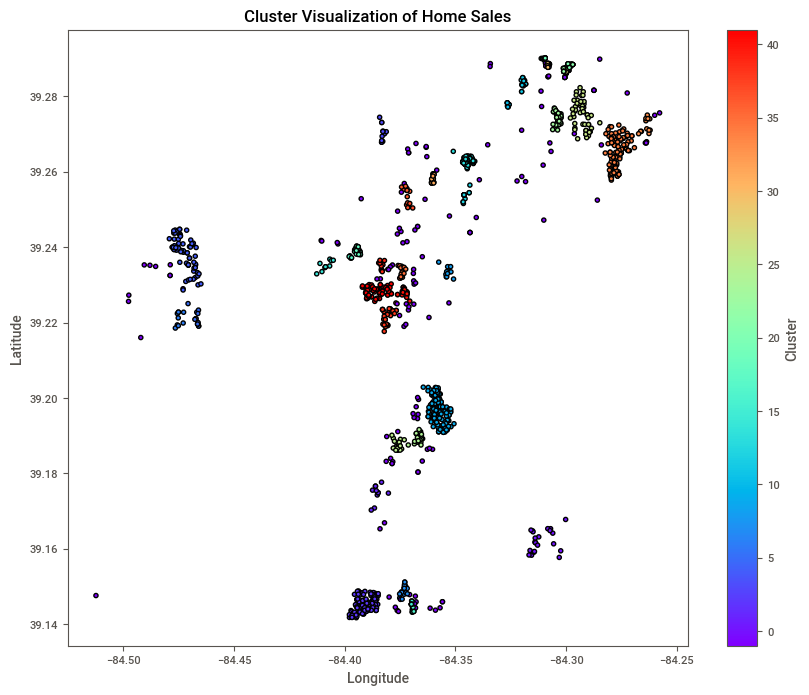

In [95]:
import matplotlib.pyplot as plt

# Extract latitude, longitude, and cluster information
latitudes = homes['latitude']
longitudes = homes['longitude']
clusters = homes['cluster']

# Create a scatter plot, coloring each point by its cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(longitudes, latitudes, c=clusters, cmap='rainbow', marker='o', edgecolor='k')

# Add a legend and labels
plt.title('Cluster Visualization of Home Sales')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Cluster')
plt.show()